# Analyse SHAP values

In [1]:
PATH = "/home/WUR/katz001/PROJECTS/permit-nsti-gas"

import os
import numpy as np
import json
import pandas as pd
import sys 
import errno  
import seaborn as sns
sys.path.append(f"{PATH}/scripts")

import matplotlib.pyplot as plt 
from func_preprocess import pipe_imputation_scaling, pipe_supervisedSelector
import shap
import pickle

from sklearn.pipeline import Pipeline

/home/WUR/katz001/miniconda3/envs/env_permit_gas/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
### Read dataset and split
''' 
Prepare data --> change here for different setups!
'''
datasetTimepoint = "PRESURGERY"
target = "Conclusion_micro"
percentBoruta = 100
n_iter = 1000

''' 
Select features
'''
vars = f"{target}_bootstrapped_iterativeBoruta_{percentBoruta}perc"    
varPath = f"{PATH}/results/20_featureSelection/{datasetTimepoint}/CV/{vars}.txt"
sel_variables = pd.read_csv(varPath, header=None)[0].tolist()

''' 
Define paths
'''
folderFigures = f"{PATH}/figures/{datasetTimepoint}/40_internalValidation"
resultsPath = f"{PATH}/results/40_internalValidation/{datasetTimepoint}/"
dataPath = f"{PATH}/results/10_preprocessed"
dataset = f"{datasetTimepoint}_{target}_preprocessed.csv"

''' 
Split data
'''

with open(f"{PATH}/data/data_dtypes.json", "r") as f:
    dtypes = json.load(f)
data = pd.read_csv(f"{dataPath}/{dataset}", index_col=0, dtype=dtypes)
tmp = data.select_dtypes(include=["float32"]).columns 
data[tmp] = data[tmp].astype(pd.Int64Dtype())

X = data.drop(target, axis=1)
y = data[target]

In [9]:
''' Load SHAP'''
model = 'rfc'
with open(f'{resultsPath}/bootstrap_{model}_n{n_iter}_shap.pickle', 'rb') as f:
    dic_shap = pickle.load(f)
### sort
dic_shap = dict(sorted(dic_shap.items()))

average_shap_values = []
for k,v in dic_shap.items():
    average_shap_values.append(np.array(v).mean(axis=0)) 

In [5]:
''' 
Prepare dataframe for plotting
'''
num_columns = X.loc[:,sel_variables].select_dtypes(include=["float64"]).columns
bin_columns = X.loc[:,sel_variables].select_dtypes(include=["int64"]).columns
cat_columns = X.loc[:,sel_variables].select_dtypes(include=["object"]).columns
preprocessor = pipe_imputation_scaling(num_columns, bin_columns, cat_columns)  


pipe = Pipeline([("selector", pipe_supervisedSelector(sel_variables)),
                        ("imputation", preprocessor)])
X_imputed_plotting = pipe.fit_transform(X)
columnOrderAfterPreprocessing = [ele[5:] for ele in pipe["imputation"].get_feature_names_out()]
df_plotting = pd.DataFrame(X_imputed_plotting[list(dic_shap.keys())], columns=columnOrderAfterPreprocessing)

### INverse transform numerical variables to add to interpretability
num_inverseTransform = pipe[1].transformers_[0][1][0].inverse_transform(df_plotting.loc[:,pipe[1].transformers_[0][2].tolist()])
df_plotting.loc[:,pipe[1].transformers_[0][2].tolist()] = num_inverseTransform
print(columnOrderAfterPreprocessing)

['creatinine_preop', 'hgb_preop', 'AGE', 'UPPER_ARM_ARRIVAL', 'LOWER_ARM_ARRIVAL', 'ANOGENITAL_ARRIVAL', 'DIABETES', 'SURGERY_BEFORE']


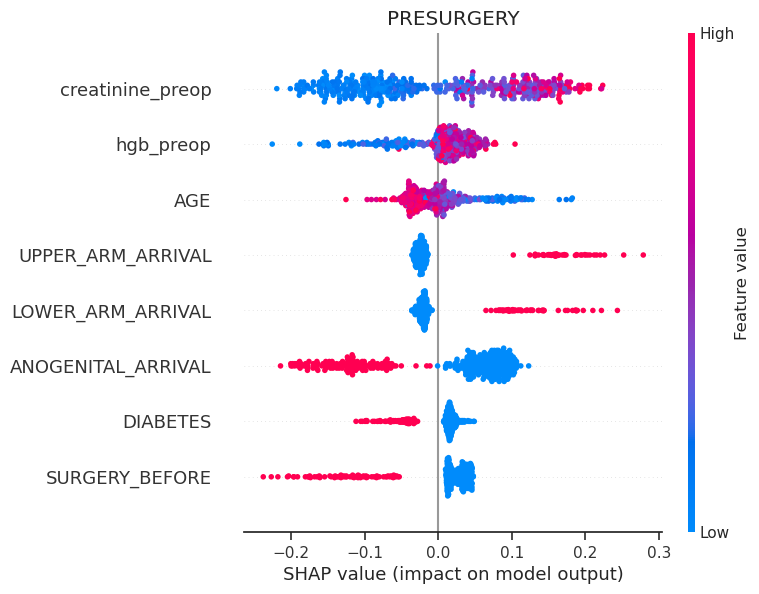

In [10]:
sns.set_theme(style="white", font_scale=1.2)
shap.summary_plot(np.array(average_shap_values), 
                  features=df_plotting,
                  show = False, sort=False, plot_size=(8.0,6.0))
plt.title(f'{datasetTimepoint}')
plt.savefig(f"{folderFigures}/SHAP_n{n_iter}_{datasetTimepoint}.png", dpi=300)

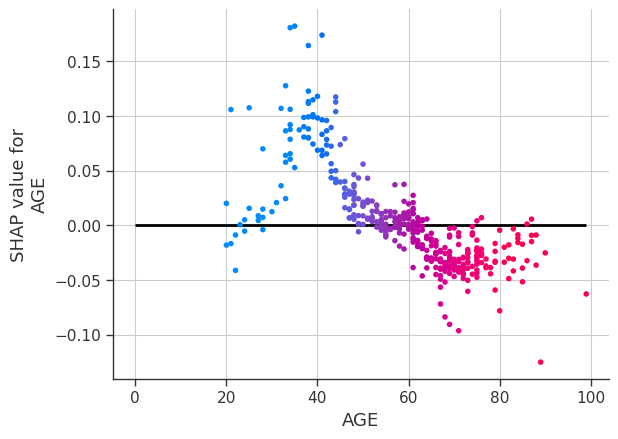

In [12]:
a = "AGE"

sns.set_theme(style="whitegrid", font_scale=1.2, context="paper")
fig, ax = plt.subplots()
ax.hlines(y=0, xmin=0, xmax=df_plotting.loc[:,a].max(), linestyles="-", colors='black', alpha=1, linewidth=2,zorder=1)
shap.dependence_plot(a, np.array(average_shap_values), 
                     df_plotting, 
                     interaction_index=a,
                     ax=ax) 